> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Generate handwritten digits with a VAE (PyTorch)

The goal here is to train a VAE to generate handwritten digits.

![VAE digits](images/vae_digits.png)

## Environment setup

In [1]:
import os
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [3]:
# Import ML packages (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 1.7.0


## Data loading

In [4]:
# Load MNIST dataset
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor(), download=True
)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data\MNIST\raw\train-images-idx3-ubyte.gz
 97%|█████████▋| 9633792/9912422 [00:03<00:00, 3376732.42it/s]Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data\MNIST\raw\train-labels-idx1-ubyte.gz

 57%|█████▋    | 16384/28881 [00:00<00:00, 67603.88it/s]

0it [00:00, ?it/s]Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:12, 132451.62it/s]

  5%|▍         | 81920/1648877 [00:00<00:09, 170734.05it/s]

 12%|█▏        | 204800/1648877 [00:00<00:06, 230137.12it/s]

 26%|██▋       | 434176/1648877 [00:00<00:03, 313967.34it/s]

 49%|████▉     | 811008/1648877 [00:00<00:01, 432777.60it/s]

 81%|████████  | 1335296/1648877 [00:00<00:00, 596773.87it/s]


0it [00:00, ?it/s

### Question

Create batch data loaders `trainloader` and `testloader` resp. for training and test datasets.

In [18]:
batch_size = 128

# YOUR CODE HERE
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
                                          
testloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

## Model definition

### Question

Complete the following class to create a variational autoencoder.

In [23]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        """Encode input into its latent representation
        Returns mean and standard deviation"""
        
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def sample(self, mu, log_var):
        """Sample a random codings vector from a gaussian distribution
        Takes mean and log_var (gamma) as parameters"""
        
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode codings"""
        
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        """Encode inputs to obtain mean and standard deviation
           Sample codings from gaussian distribution using mean and std
           Returns decoded codings, mean and standard deviation"""
        # YOUR CODE HERE

        mu, log_var = self.encode(x)
        z = self.sample(mu, log_var)
        return self.decode(z), mu, log_var

## Model training

### Question

Complete the following training loop to:
- instantiate the variational autoencoder on target device.
- instanciate the Adam optimizer.
- implement forward pass and gradient descent.

In [45]:
input_dim = 784
hidden_dim = 400
latent_dim = 20
num_epochs = 15
learning_rate = 1e-3
prints_per_epoch = 1  # Increase to see more feedback during training

# Instanciate VAE and optimizer
# YOUR CODE HERE
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(trainloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # YOUR CODE HERE
        x = x.to(device)
        x = torch.flatten(x, start_dim=1)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction="sum")
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div

        # Backprop and optimize
        # YOUR CODE HERE
        loss.backward()
        optimizer.step()

        # Print losses at regular intervals
        step_count = len(trainloader)
        print_threshold = math.ceil(step_count / prints_per_epoch)
        if (i + 1) % print_threshold == 0 or (i + 1) == step_count:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", step [{i + 1}/{step_count}]"
                f", reconst loss: {reconst_loss.item():.4f}"
                f", KL div: {kl_div.item():.4f}"
            )

Epoch [1/15], step [469/469], reconst loss: 10360.1680, KL div: 2066.5129
Epoch [2/15], step [469/469], reconst loss: 8810.5469, KL div: 2327.7461
Epoch [3/15], step [469/469], reconst loss: 8582.4092, KL div: 2382.5742
Epoch [4/15], step [469/469], reconst loss: 8586.5254, KL div: 2374.5830
Epoch [5/15], step [469/469], reconst loss: 8504.0488, KL div: 2349.4724
Epoch [6/15], step [469/469], reconst loss: 7483.6602, KL div: 2352.9939
Epoch [7/15], step [469/469], reconst loss: 7982.9976, KL div: 2440.9751
Epoch [8/15], step [469/469], reconst loss: 7799.0342, KL div: 2449.7959
Epoch [9/15], step [469/469], reconst loss: 7906.2163, KL div: 2374.8188
Epoch [10/15], step [469/469], reconst loss: 8263.8574, KL div: 2463.0576
Epoch [11/15], step [469/469], reconst loss: 8271.0801, KL div: 2444.7021
Epoch [12/15], step [469/469], reconst loss: 8138.8398, KL div: 2491.8911
Epoch [13/15], step [469/469], reconst loss: 7776.4697, KL div: 2453.9453
Epoch [14/15], step [469/469], reconst loss: 7

## Reconstructions visualization¶

In [56]:
def plot_image(image):
    plt.imshow(image.cpu().numpy().squeeze(), cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    """Show original and reconstructed images side-by-side"""
    
    inputs = images.reshape(-1, 28*28).to(device)
    reconstructions, _, _ = model(inputs)
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index].view(1, 28, 28))

### Question

Show reconstructions for one batch of test data.

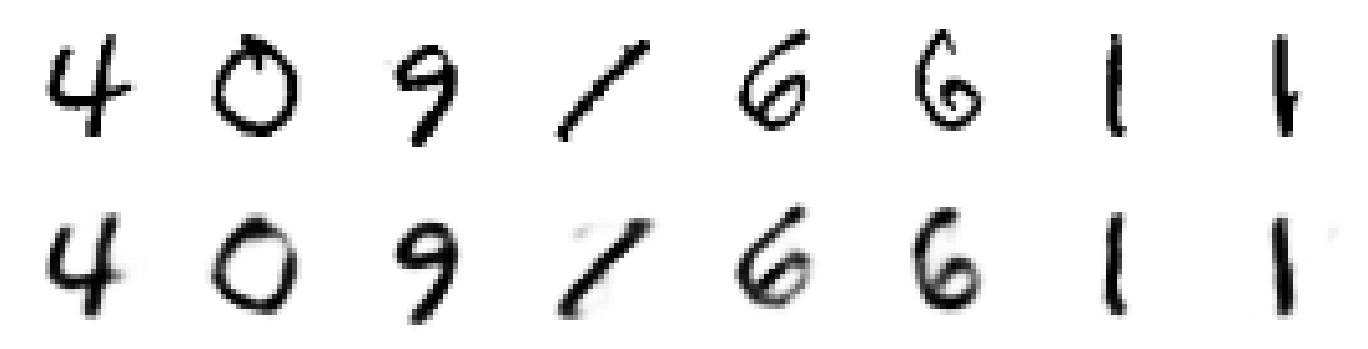

In [58]:
# YOUR CODE HERE
images, _ = next(iter(testloader))
with torch.no_grad():
    show_reconstructions(model, images, n_images=8)

## Generating new images¶

In [61]:
def plot_multiple_images(images, n_cols=None):
    """Show a series of images"""

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 1.5, 3))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image.cpu().numpy().squeeze(), cmap="binary")
        plt.axis("off")

### Question

Use the VAE to show several generated digits.

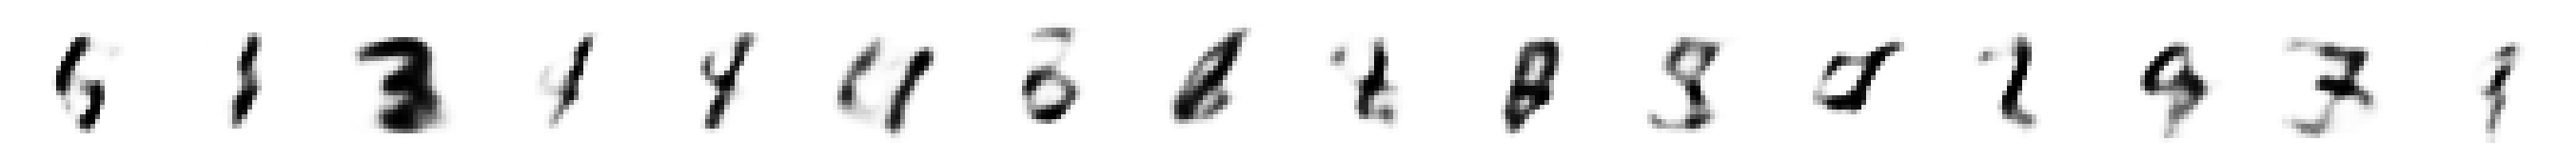

In [63]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    # YOUR CODE HERE
    images = model.decode(z)
    images = images.view(-1, 1, 28, 28)
    plot_multiple_images(images, n_cols=16)